In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap

/home/rico/miniconda3/envs/biomlhack/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sm2receptor = pd.read_csv('data/pairs.csv', sep=';')

In [4]:
sm2receptor['Mixture'].value_counts()

Mixture
mono              39230
sum of isomers    10920
mixture            1265
Name: count, dtype: int64

In [5]:
sm2receptor['Species'].value_counts()

Species
homo sapiens              40898
mus musculus              10242
pan troglodytes              55
pongo abelii                 50
bos taurus                   41
pan paniscus                 26
ovis aries                   25
canis lupus familiaris       25
vulpes vulpes                25
puma concolor                25
rattus norvegicus             3
Name: count, dtype: int64

In [6]:
sm2receptor['Mutation'].value_counts().head(20)

Mutation
D296N                                                                                                                            143
+1M                                                                                                                              124
Q293R                                                                                                                            122
M81V                                                                                                                              97
C149W                                                                                                                             67
L40Q                                                                                                                              64
V118M_Q234R                                                                                                                       64
F75S                                                        

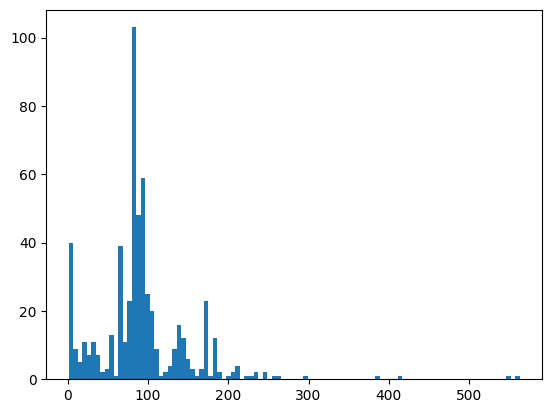

In [7]:
plt.hist(sm2receptor['Gene Name'].value_counts(), bins=100);

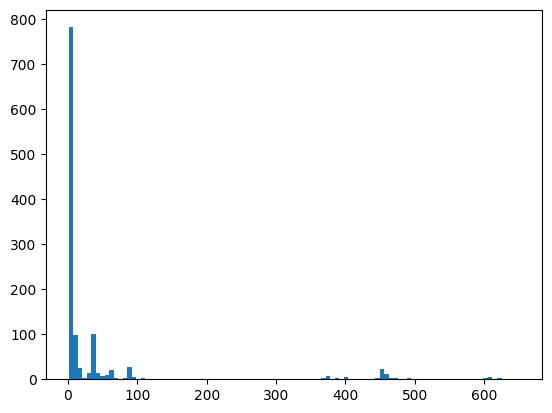

In [8]:
plt.hist(sm2receptor['Molecule Name'].value_counts(), bins=100);

In [9]:
sm2receptor['Responsive'].value_counts()

Responsive
0    48307
1     3108
Name: count, dtype: int64

In [10]:
sm2lang = pd.read_csv('data/Multi-Labelled_Smiles_Odors_dataset.csv')

In [11]:
sm2lang = sm2lang.rename({'nonStereoSMILES': 'SMILES'}, axis=1)

In [12]:
sm2lang['descriptors'].value_counts().head(20)

descriptors
odorless                                     199
fruity                                        42
waxy                                          24
fatty                                         24
sulfurous                                     20
woody                                         18
sweet                                         16
green                                         13
caramellic                                    13
spicy                                         12
fatty;oily                                    11
herbal                                        10
musk                                           9
fatty;waxy                                     9
floral                                         9
phenolic                                       8
gassy                                          8
vegetable;cognac;alcoholic;green;ethereal      8
fishy                                          8
balsamic                                       8
Name: co

In [13]:
sm2receptor.shape, sm2lang.shape

((51415, 14), (4983, 140))

In [14]:
sm2receptor.merge(sm2lang, on='SMILES', how='inner')['Responsive'].value_counts()

Responsive
0    10213
1      485
Name: count, dtype: int64

In [15]:
import torch
from protein_encoder import ProteinEncoder
from text_encoder import TextEncoder
from mol_encoder import SmallMoleculeEncoder

ModuleNotFoundError: No module named 'mol_encoder'

In [ ]:
device = torch.device('cuda:2')

In [21]:
prot_enc = ProteinEncoder(config_path='facebook/esm2_t6_8M_UR50D', out_dim=256)
prot_enc.model = prot_enc.model.to(device)
prot_enc.out = prot_enc.out.to(device)

# freeze weights
for param in prot_enc.model.parameters():
    param.requires_grad = False

/home/rico/miniconda3/envs/biomlhack/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [18]:
sm2receptor['UniProt ID'].nunique(), sm2receptor['Sequence'].nunique(), sm2receptor[['UniProt ID', 'Sequence']].nunique()

(589,
 1254,
 UniProt ID     589
 Sequence      1254
 dtype: int64)

In [35]:
uniprot2seq = sm2receptor[['UniProt ID', 'Sequence']].set_index('UniProt ID')['Sequence'].to_dict()
uniprot2species = sm2receptor[['UniProt ID', 'Species']].set_index('UniProt ID')['Species'].to_dict()

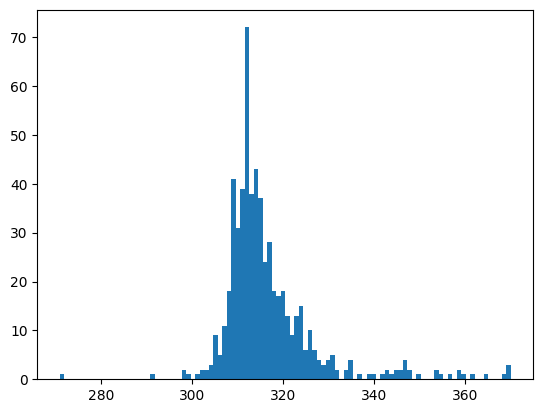

In [20]:
plt.hist([len(s) for s in uniprot2seq.values()], bins=100);

In [20]:
enc = prot_enc.tokenizer.encode(uniprot2seq['Q8NGN2'])

In [21]:
protein_inputs = prot_enc.tokenizer.batch_encode_plus(uniprot2seq['Q8NGN2'], return_tensors="pt", padding=True)
protein_inputs = {k: v.to(device) for k, v in protein_inputs.items()}
output, _ = prot_enc.forward(protein_inputs)

In [23]:
emb = prot_enc.get_repr(list(uniprot2seq.values()), batch_size=16, verbose=True).numpy(force=True)

Computing protein embeddings:   0%|          | 0/37 [00:00<?, ?it/s]

Computing protein embeddings: 100%|██████████| 37/37 [00:00<00:00, 46.25it/s]


In [34]:
u = umap.UMAP(n_neighbors=10).fit_transform(emb)
u = pd.DataFrame(u)
u['uniprot_id'] = uniprot2seq.keys()
u['species'] = u['uniprot_id'].map(uniprot2species)

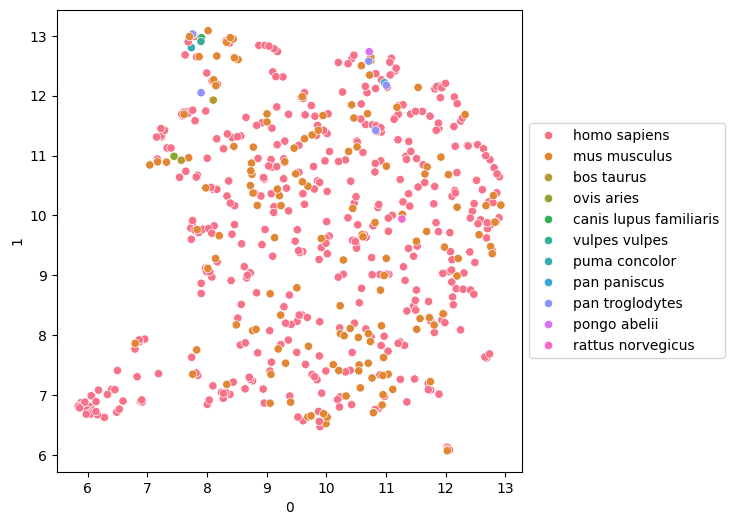

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
sns.scatterplot(u, x=0, y=1, hue='species', ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [46]:
text_enc = TextEncoder(config_path='microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext', out_dim=256)
text_enc.model = text_enc.model.to(device)
text_enc.out = text_enc.out.to(device)

# freeze weights
for param in text_enc.model.parameters():
    param.requires_grad = False

/home/rico/miniconda3/envs/biomlhack/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [49]:
text_emb = text_enc.get_repr(sm2lang['descriptors'], batch_size=16, verbose=True).numpy(force=True)

Computing text embeddings: 100%|██████████| 312/312 [00:02<00:00, 135.27it/s]


In [52]:
u = umap.UMAP(n_neighbors=10).fit_transform(text_emb)
u = pd.DataFrame(u)
u['descriptors'] = sm2lang['descriptors']

<Axes: xlabel='0', ylabel='1'>

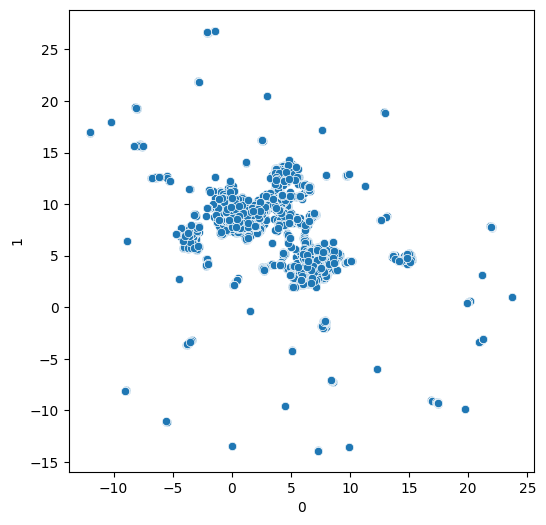

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
sns.scatterplot(u, x=0, y=1, ax=ax)

In [40]:
sm_enc = SmallMoleculeEncoder(config_path="ibm/MoLFormer-XL-both-10pct", out_dim=256)
sm_enc.model = sm_enc.model.to(device)
sm_enc.out = sm_enc.out.to(device)

# freeze weights
for param in sm_enc.model.parameters():
    param.requires_grad = False

In [44]:
sm_emb = sm_enc.get_repr(list(sm2receptor['SMILES'].unique()), batch_size=16, verbose=True).numpy(force=True)

Computing protein embeddings: 100%|██████████| 48/48 [00:00<00:00, 59.08it/s]


In [47]:
u = umap.UMAP(n_neighbors=10).fit_transform(sm_emb)
u = pd.DataFrame(u)

/home/rico/miniconda3/envs/biomlhack/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


<Axes: xlabel='0', ylabel='1'>

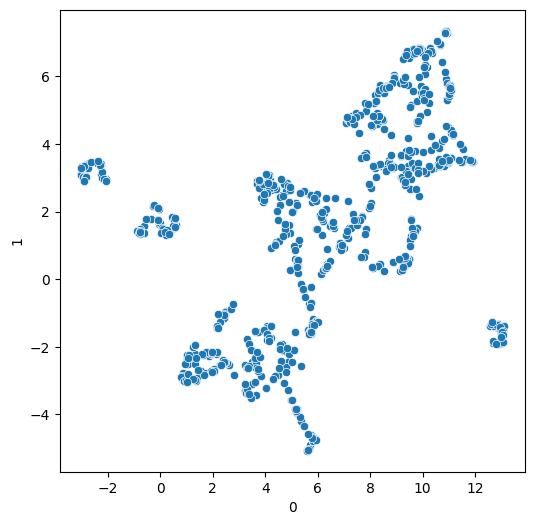

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
sns.scatterplot(u, x=0, y=1, ax=ax)

In [39]:
from trimodal_model import TrimodalModel
from pytorch_lightning import Trainer
import numpy as np

In [106]:
merged = sm2receptor.merge(sm2lang, on='SMILES', how='outer')
merged = merged[merged['Responsive']==1]
merged['descriptors'] = merged['descriptors'].fillna('unknown')
merged = merged[merged['Species'].isin(['homo sapiens', 'mus musculus'])]

In [18]:
from torch.utils.data import Dataset, DataLoader

In [108]:
class CustomDataset(Dataset):

    def __init__(self, protein_seqs, text_seqs, sm_seqs):
        self.protein_seqs = protein_seqs
        self.text_seqs = text_seqs
        self.sm_seqs = sm_seqs

    def __len__(self):
        return len(self.protein_seqs)

    def __getitem__(self, idx):
        protein_inputs = self.protein_seqs[idx]
        text_inputs = self.text_seqs[idx]
        sm_inputs = self.sm_seqs[idx]
        return protein_inputs, text_inputs, sm_inputs

    def collate_fn(self, batch):
        protein_inputs, text_inputs, sm_inputs = zip(*batch)
        batch_size = len(protein_inputs)
        
        protein_inputs_batch = model.protein_encoder.tokenizer.batch_encode_plus(protein_inputs, return_tensors="pt", padding=True)
        text_inputs_batch = model.text_encoder.tokenizer.batch_encode_plus(text_inputs, return_tensors="pt", padding=True)
        sm_inputs_batch = model.sm_encoder.tokenizer.batch_encode_plus(sm_inputs, return_tensors="pt", padding=True)

        labels = torch.linspace(0, batch_size - 1, batch_size, dtype=int)
        return (protein_inputs_batch, text_inputs_batch, sm_inputs_batch), labels

In [109]:
all_smiles = sorted(merged['SMILES'].unique(), key=lambda x: np.random.rand())
# hold out 10% for testing
train_smiles = all_smiles[:int(len(all_smiles)*0.9)]
merged['split'] = 'train'
merged.loc[~merged['SMILES'].isin(train_smiles), 'split'] = 'val'
merged['split'].value_counts()

split
train    2632
val       271
Name: count, dtype: int64

In [110]:
train_data = merged[merged['split']=='train']
val_data = merged[merged['split']=='val']

train_protein_seqs, train_sm_seqs, train_text_seqs = train_data['Sequence'].to_list(), train_data['SMILES'].to_list(), train_data['descriptors'].to_list()
val_protein_seqs, val_sm_seqs, val_text_seqs = val_data['Sequence'].to_list(), val_data['SMILES'].to_list(), val_data['descriptors'].to_list()
train_dataset = CustomDataset(train_protein_seqs, train_text_seqs, train_sm_seqs)
val_dataset = CustomDataset(val_protein_seqs, val_text_seqs, val_sm_seqs)

train_dl = DataLoader(train_dataset, batch_size=32, collate_fn=train_dataset.collate_fn, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=32, collate_fn=val_dataset.collate_fn, shuffle=False)

In [76]:
from pytorch_lightning.loggers import WandbLogger
import wandb
from datetime import datetime

In [123]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▇█▆▅▇▅▆▄▃▂▃▄▄▁▂▃▃▆
train_loss,█▇█▇▇▆▇▅▇▅▇▇▆▄▆▃▄▇▃▅▆▄▁▆▄▅▆▇▅▅▄▄▂▆▂▂▃▅▅▅
train_protein_sm_acc,▂▂▂▃▁▂▁▃▃▂▁▁▂▂▃▅▂▃▁▃▁▂▃▂▂▃█▂▂▅▂▂▆▃▃▆▇▃▁▃
train_protein_text_acc,▃▃▃▃▅▅▃▃▅▃▅▅▅▃▃▆▃▃▁▃▅█▆▆▅▅▁▅▃▅▆▅▃▃▅▆▅▁▃▅
train_sm_text_acc,▂▁▂▂▂▁▁▂▄▂▃▃▄▄▅▅▁▂▃▆▃▅▅▆▅▅▂▂▄▂▅█▄▄▅▅▃▄▃▅
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,▇▇▆▅▁▆▇▇▇▆▄▁▆▇▇▇▆▄▁▆▇▇▇▇▄▁▆▇▇▇▇▄▁▆▆█▇▇▄▁
valid_protein_sm_acc,▁▁▅▅▅▅▁▅▁▅▅▅▅▁▅▁▅▅▅▅▁▅▁▁▅▅▅▁▅▁▁▅▅▅▁█▁▁█▅
valid_protein_text_acc,▁▁▁▅▅▅▁▁▁▁▁▅▁▁▅▁▁▁▅▅▁▁▁▁▁▅▁▁▁▁▁█▅▁▁▁▁▁▅▅


In [124]:
run_id = datetime.now().strftime("%Y%m%d%H%M")
wandb_logger = WandbLogger(project='biomlhackathon', name=f'test_{run_id}')

In [125]:
model = TrimodalModel(
    protein_config='facebook/esm2_t30_150M_UR50D',
    text_config='microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext',
    sm_config='ibm/MoLFormer-XL-both-10pct',
    lr_scheduler_kwargs={
        "class": "ConstantLRScheduler",
        "init_lr": 1e-2,
    }
)

/home/rico/miniconda3/envs/biomlhack/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


No optimizer_kwargs provided. The default optimizer is AdamW.


/home/rico/miniconda3/envs/biomlhack/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [126]:
trainer = Trainer(accelerator="gpu", devices=1, max_epochs=50, logger=wandb_logger)
trainer.fit(model, train_dl, val_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name                 | Type                 | Params
--------------------------------------------------------------
0 | protein_encoder      | ProteinEncoder       | 148 M 
1 | text_encoder         | TextEncoder          | 109 M 
2 | sm_encoder           | SmallMoleculeEncoder | 44.6 M
3 | model                | ParameterList        | 301 M 
4 | train_protein_sm_acc | Accuracy             | 0     
5 | train_sm_text_acc    | Accuracy             | 0     
6 | valid_protein_sm_acc | Accuracy             | 0     
7 | valid_sm_text_acc    | Accuracy             | 0     
8 | test_protein_sm_acc  | Accuracy             | 0     
9 | test_sm_text_acc     | Accuracy             | 0     
--------------------------------------------------------------
557 K     Trainable params
301 M     Non-trainable params
301 M     Total params
1,207.856 Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/rico/miniconda3/envs/biomlhack/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


/home/rico/miniconda3/envs/biomlhack/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 44:  27%|██▋       | 22/83 [00:09<00:26,  2.27it/s, v_num=k80r, loss=3.030]

/home/rico/miniconda3/envs/biomlhack/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
